In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert import focuss
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

# Get Forward Model

In [2]:
info = get_info(kind='biosemi256')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


# Get sample data

In [66]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=5, extents=(1, 45), duration_of_trial=0.01, target_snr=99999999999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
M = evoked.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 143.24it/s]

Using control points [2.58613010e-09 6.55295514e-09 7.14570755e-08]


# Minimum Norm Estimate

In [67]:
alpha = 0.001
# if n_chans>n_dipoles:
# D_MNE = np.linalg.inv(leadfield.T @ leadfield + alpha * np.identity(n_dipoles)) @ leadfield.T @ M
# else:
D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M


stc_hat = stc.copy()
stc_hat.data = D_MNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE', 'title',
               font_size=14)

Using control points [5.34789642e-09 6.98039313e-09 4.34713635e-08]


# Weighted Minimum Norm Estimate

In [68]:
alpha = 0.001
omega = np.diag(np.linalg.norm(leadfield, axis=0))
I_3 = np.identity(3)
W = omega # np.kron(omega, I_3)

D_WMNE = np.linalg.inv(W.T @ W) @ leadfield.T  @ np.linalg.inv(leadfield @ np.linalg.inv(W.T @ W) @ leadfield.T + alpha * np.identity(n_chans)) @ M

stc_hat = stc.copy()
stc_hat.data = D_WMNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'wMNE', 'title',
               font_size=14)

Using control points [4.26220895e-09 5.56245916e-09 2.67300049e-08]


# MNE with FOCUSS (Focal underdetermined system solution)

In [69]:
alpha = 0.001

D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M
D_FOCUSS = focuss(D_MNE, M, leadfield, alpha)



stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE FOCUSS', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

Using control points [3.59272975e-155 7.31899727e-153 7.77102550e-137]
0.4165975694380615


[0.21544287477772395,
 0.32961444149465924,
 0.42246197227311966,
 -0.3922905309787199,
 0.571776994105253,
 0.7592482959574124,
 0.48184977870863693,
 0.41073316660300324,
 0.4446990042419957,
 0.1990835212572586]

# LORETA

In [70]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
# D_LOR = np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ (leadfield @ np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T + alpha * np.identity(n_chans) ) @ M

stc_hat = stc.copy()
stc_hat.data = D_LOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LORETA', 'title',
            font_size=14)

-- number of adjacent vertices : 1284
Using control points [1.13791953e-08 1.40603620e-08 4.06087774e-08]


# LORETA FOCUSS

In [71]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
D_FOCUSS = focuss(D_LOR, M, leadfield, alpha)


stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LORETA FOCUSS', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

Using control points [3.27885914e-149 1.90953241e-147 4.03765759e-136]
0.2415712970881534


[0.23746419322389128,
 0.2128227988627943,
 0.5027341737588263,
 0.03057682901334103,
 0.15884723596138564,
 -0.003331356847955029,
 0.34219397157618553,
 0.33614996520238216,
 0.4639147952296974,
 0.2456784009524155]

# sLORETA

In [72]:
alpha = 0.001
K_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans))
D_MNE = K_MNE @ M
W_diag = 1 / np.diag(K_MNE @ leadfield)

W_slor = np.diag(W_diag)

W_slor = np.sqrt(W_slor)

K_slor = W_slor @ K_MNE
D_SLOR = K_slor @ M
D_SLOR[np.isnan(D_SLOR)] = 0

stc_hat = stc.copy()
stc_hat.data = D_SLOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'sLORETA', 'title',
            font_size=14)

Using control points [1.78811467e-08 2.24654995e-08 6.76567104e-08]


C:\Users\Lukas\AppData\Local\Temp/ipykernel_9268/719602940.py:8: RuntimeWarning: invalid value encountered in sqrt
  W_slor = np.sqrt(W_slor)


# sLORETA FOCUSS

In [73]:
alpha = 0.001
K_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans))
D_MNE = K_MNE @ M
W_diag = 1 / np.diag(K_MNE @ leadfield)

W_slor = np.diag(W_diag)

W_slor = np.sqrt(W_slor)

K_slor = W_slor @ K_MNE
D_SLOR = K_slor @ M
D_SLOR[np.isnan(D_SLOR)] = 0

D_SLOR_FOCUSS = focuss(D_SLOR, M, leadfield, alpha)

stc_hat = stc.copy()
stc_hat.data = D_SLOR_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'sLORETA FOCUSS', 'title',
            font_size=14)

C:\Users\Lukas\AppData\Local\Temp/ipykernel_9268/3213525492.py:8: RuntimeWarning: invalid value encountered in sqrt
  W_slor = np.sqrt(W_slor)


Using control points [4.51627906e-145 6.78095810e-143 6.74864964e-132]


# eLORETA

In [74]:
from invert import calc_eloreta_D
stop_crit = 0.005
alpha = 0.001

D, C = calc_eloreta_D(leadfield, alpha, stop_crit=stop_crit)
K_elor = np.linalg.inv(D) @ leadfield.T @ np.linalg.inv( leadfield @ np.linalg.inv(D) @ leadfield.T + alpha * np.identity(n_chans) )
D_ELOR = K_elor @ M



stc_hat = stc.copy()
stc_hat.data = D_ELOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'eLORETA', 'title',
            font_size=14)


Optimizing eLORETA weight matrix W...
	rep 1
averagePercentChange=63.99 %
	rep 2
averagePercentChange=35.95 %
	rep 3
averagePercentChange=17.91 %
	rep 4
averagePercentChange=8.64 %
	rep 5
averagePercentChange=4.15 %
	rep 6
averagePercentChange=2.01 %
	rep 7
averagePercentChange=0.98 %
	rep 8
averagePercentChange=0.48 %
	...converged...
	...done!
Using control points [6.21650338e-09 8.18948374e-09 3.55363590e-08]


# eLORETA FOCUSS

In [75]:
from invert import calc_eloreta_D
stop_crit = 0.005
alpha = 0.001

# D, C = calc_eloreta_D(leadfield, alpha, stop_crit=stop_crit)
# K_elor = np.linalg.inv(D) @ leadfield.T @ np.linalg.inv( leadfield @ np.linalg.inv(D) @ leadfield.T + alpha * np.identity(n_chans) )
# D_ELOR = K_elor @ M
d_ELOR_FOCUSS = focuss(D_ELOR, M, leadfield, alpha)


stc_hat = stc.copy()
stc_hat.data = D_ELOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'eLORETA FOCUSS', 'title',
            font_size=14)


Using control points [6.21650338e-09 8.18948374e-09 3.55363590e-08]


# LAURA

In [76]:
alpha = 200
drop_off = 2
d = cdist(pos, pos)
# Get the adjacency matrix of the source spaces
adj = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
for i in range(d.shape[0]):
    # find dipoles that are no neighbor to dipole i
    non_neighbors = np.where(~adj.astype(bool)[i, :])[0]
    # append dipole itself
    non_neighbors = np.append(non_neighbors, i)
    # set non-neighbors to zero
    d[i, non_neighbors] = 0
A = -d**-drop_off
A[np.isinf(A)] = 0
W = np.identity(A.shape[0])
M_j = W @ A

# Source Space metric
W_j = np.linalg.inv(M_j.T @ M_j)
W_j_inv = np.linalg.inv(W_j)

W_d = np.linalg.inv(np.identity(n_chans))
noise_term = (alpha**2) * np.linalg.inv(W_d)
G = W_j_inv @ leadfield.T @ np.linalg.inv(leadfield @ W_j_inv @ leadfield.T + noise_term)
D_LAURA = G @ M

stc_hat.data = D_LAURA
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LAURA', 'title',
            font_size=14)

C:\Users\Lukas\AppData\Local\Temp/ipykernel_9268/1970925425.py:13: RuntimeWarning: divide by zero encountered in power
  A = -d**-drop_off


Using control points [1.67769793e-09 1.98576912e-09 4.63104213e-09]


# VARETA

In [77]:
# 1) J & JVareta given; find A
# 2) A given, find J
# 3) repeat until convergence

In [78]:
 
# alpha = 0.001
# adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
# B = np.diag(np.linalg.norm(leadfield, axis=0))
# L = laplacian(adjacency)  # non-singular univariate discrete laplacian -> is that correct?
# D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ L.T @ L @ B) @ leadfield.T @ M
# D_Last = deepcopy(D_LOR)[:, 0][:, np.newaxis]
# W = np.diag(np.linalg.norm(leadfield, axis=0))  # WMNE weight matrix (depth weighting)
# tau = 1  # controls smoothness
# alpha_2 = 1  # controls importance of grid point
# # for t in range(M.shape[1]):
# t = 0
# A = np.identity(n_dipoles)  # in paper: large lambda
    
# # for _ in range(10):
# term_1 = np.linalg.norm( M[:, t] - leadfield @ D_Last )
# term_2 = np.linalg.norm( A@L * W * D_Last )
# term_3 = tau**2 * np.linalg.norm( L * np.diag(np.log(np.diagonal(A))) - alpha_2 )


# # D_VAR = term_1 + term_2 + term_3

# from scipy.optimize import minimize
# def find_lambda(A, m, leadfield, D_Last, L, W, tau, alpha_2):
#     A = A.reshape(leadfield.shape[1], leadfield.shape[1])
#     term_1 = np.linalg.norm( M[:, t] - leadfield @ D_Last )
#     term_2 = np.linalg.norm( A@L * W * D_Last )
#     term_3 = tau**2 * np.linalg.norm( L * np.diag(np.log(np.diagonal(A))) - alpha_2 )
#     return term_1 + term_2 + term_3
# # find_lambda(A, M[:, t], leadfield, D_Last, L, W, tau, alpha_2)
# minimize(find_lambda, A.flatten(), args=(M[:, t], leadfield, D_Last, L, W, tau, alpha_2), method='L-BFGS-B')

# S-MAP

In [79]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M

gradient = np.gradient(B)[0] #np.gradient(B)[0]
D_SMAP = np.linalg.inv(leadfield.T @ leadfield + alpha * gradient.T @ gradient) @ leadfield.T @ M
# D_SMAP = np.linalg.inv(gradient.T @ gradient) @ leadfield.T @ np.linalg.inv(leadfield @ np.linalg.inv( gradient.T @ gradient ) @ leadfield.T + alpha * np.identity(n_chans)) @ M

stc_hat = stc.copy()
stc_hat.data = D_SMAP
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'S-MAP', 'title',
            font_size=14)

-- number of adjacent vertices : 1284
Using control points [1.46284964e-08 1.80781913e-08 4.77485104e-08]


# ESINET

In [80]:
# from esinet import Net
# import tensorflow as tf
# sim_train = Simulation(fwd, info, settings=dict(duration_of_trial=0)).simulate(5000)
# net = Net(fwd, n_lstm_layers=0, activation_function='tanh').fit(sim_train)
D_ESINET = net.predict(sim.eeg_data[0])[0].data

stc_hat = stc.copy()
stc_hat.data = D_ESINET
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'ESINET', 'title',
            font_size=14)

Using control points [5.02833721e-09 6.04822911e-09 1.37710111e-08]


c:\Users\Lukas\Envs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


# Backus-Gilbert

In [81]:
# Calculate distance matrix
# dist = cdist(pos, pos)

# print("Get W_BG")
# W_BG = []
# for i in range(n_dipoles):
#     W_gamma_BG = np.diag(dist[i, :])
#     W_BG.append(W_gamma_BG)

# print("Get C")
# C = []
# for i in range(n_dipoles):
#     C_gamma = leadfield @ W_BG[i] @ leadfield.T
#     C.append(C_gamma)

# print("Get F")
# F = leadfield @ leadfield.T

# print("Get E")
# E = []
# for i in range(n_dipoles):
#     E_gamma = C[i] + F
#     E.append(E_gamma)

# print("Get L")
# L = leadfield @ np.ones((n_dipoles, 1))

# print("Get T")
# T = []
# for i in range(n_dipoles):
#     E_gamma_pinv = np.linalg.pinv(E[i])
#     T_gamma = (E_gamma_pinv @ L) / (L.T @ E_gamma_pinv @ L)
#     T.append(T_gamma)

# T_final = np.stack(T, axis=0)[:, :, 0]
D_BG = T_final @ M

stc_hat.data = D_BG
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Backus-Gilbert', 'title',
            font_size=14)

Using control points [9.58418623e-10 1.22686026e-09 2.60513399e-08]



# LUCAS

In [83]:
stc_hat.data = np.mean([D_MNE , D_WMNE, D_LOR, D_SLOR, D_ELOR, D_LAURA, D_SMAP, D_ESINET, D_BG], axis=0)
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LUCAS', 'title',
            font_size=14)

Using control points [5.00009122e-09 6.24285688e-09 2.67275917e-08]


Using control points [1.28813272e-09 4.18199789e-09 4.96968009e-08]


  File "c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [9.03263013e-09 1.12872649e-08 4.90494288e-08]


  File "c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [4.92244265e-09 6.21384073e-09 3.04527387e-08]


  File "c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [7.76347837e-150 1.84514114e-147 6.87510741e-133]
Using control points [1.28813272e-09 4.18199789e-09 4.96968009e-08]
Using control points [7.76347837e-150 1.84514114e-147 6.87510741e-133]


  File "c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [1.42980773e-08 2.41912540e-08 4.45736264e-08]
Using control points [6.69941663e-09 8.54543146e-09 2.83591254e-08]
Using control points [1.48720272e-09 1.82987674e-09 1.74443383e-08]
Using control points [1.28813272e-09 4.18199789e-09 4.96968009e-08]
Using control points [8.98712418e-09 1.02386164e-08 1.37399575e-08]
Using control points [8.98712418e-09 1.02386164e-08 1.37399575e-08]


  File "c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [3.25834234e-140 1.53051430e-138 1.77578381e-129]
Using control points [8.98712418e-09 1.02386164e-08 1.37399575e-08]
Using control points [1.48720272e-09 1.82987674e-09 1.74443383e-08]
Using control points [1.42980773e-08 2.41912540e-08 4.45736264e-08]
Using control points [4.70705701e-145 2.28384548e-142 1.73142680e-134]
Using control points [9.74556096e-10 3.27703301e-09 3.26239090e-08]
Using control points [6.07396790e-163 1.01455929e-161 2.98426360e-150]
Using control points [3.94153424e-149 4.03242644e-148 2.46215815e-140]
Using control points [3.33405505e-09 1.23863144e-08 7.03479328e-08]


# Saved for later

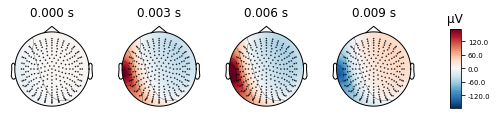

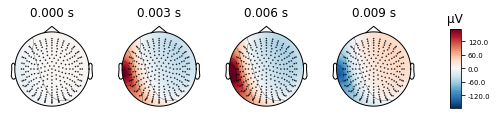

In [ ]:
from esinet.util import get_eeg_from_source
evoked_hat = get_eeg_from_source(stc_hat, fwd, info, tmin=stc.tmin)
evoked_hat.plot_topomap()

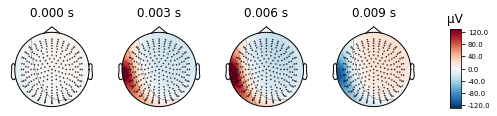

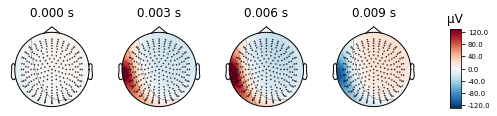

Using control points [7.96100854e-10 9.86548052e-10 1.86763183e-09]
Using control points [1.36147330e-08 2.76378574e-08 5.36183889e-08]
Using control points [1.36147330e-08 2.76378574e-08 5.36183889e-08]
Using control points [7.96100854e-10 9.86548052e-10 1.86763183e-09]
Using control points [1.15120559e-08 1.42428665e-08 2.70028726e-08]
Using control points [1.36147330e-08 2.76378574e-08 5.36183889e-08]
Using control points [6.50443967e-09 1.32039883e-08 2.56161892e-08]
Using control points [1.36758841e-09 2.49483056e-09 4.00931931e-09]
Using control points [7.96100854e-10 9.86548052e-10 1.86763183e-09]
Using control points [1.98574037e-08 3.62249762e-08 5.82153749e-08]


  File "c:\Users\Lukas\Envs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [1.15120559e-08 1.42428665e-08 2.70028726e-08]
Using control points [8.27506809e-09 1.50958378e-08 2.42597773e-08]
Using control points [9.75271566e-10 1.41978281e-09 2.35340139e-09]
Using control points [5.68118795e-09 8.38007548e-09 1.38561205e-08]


In [ ]:
evoked.plot_topomap()